In [61]:
import numpy as np
import torch
from env import MultiAgentEnv
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import pandas as pd
import json
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import random
from collections import deque
from new_env import New_env
import gymnasium as gym
from sklearn.metrics import f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from joblib import dump, load
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [62]:
#TRAIN
X_train = pd.read_csv('/Users/louisedurand-janin/Documents/GitHub/HrFlow_Data_Challenge/data/X_train.csv')
X_train['employee embedding'] = X_train['employee embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float32))
X_train['company embedding'] = X_train['company embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float32))

In [63]:
#TEST
X_test = pd.read_csv('/Users/louisedurand-janin/Documents/GitHub/HrFlow_Data_Challenge/data/X_test.csv')
X_test['employee embedding'] = X_test['employee embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float32))
X_test['company embedding'] = X_test['company embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float32))

In [64]:
#TRAIN
y_train = pd.read_csv('/Users/louisedurand-janin/Documents/GitHub/HrFlow_Data_Challenge/data/y_train.csv', index_col=0)
encoding_map = {
        "Assistant": 0,
        "Executive": 1,
        "Manager": 2,
        "Director": 3,
    }

y_train = np.array([encoding_map[category] for category in y_train['position']])

In [14]:
#TEST

y_test = pd.read_csv('/Users/louisedurand-janin/Documents/GitHub/HrFlow_Data_Challenge/data/y_test.csv', index_col=0)
encoding_map = {
        "Assistant": 0,
        "Executive": 1,
        "Manager": 2,
        "Director": 3,
    }

y_test = np.array([encoding_map[category] for category in y_test['position']])

In [65]:
#TRAIN

employee_array = np.vstack(X_train['employee embedding'].values)
employee_array.shape
company_array = np.vstack(X_train['company embedding'].values)
company_array.shape

(29273, 32)

In [66]:
# TEST
employee_array_test = np.vstack(X_test['employee embedding'].values)
employee_array_test.shape
company_array_test = np.vstack(X_test['company embedding'].values)
company_array_test.shape

(7327, 32)

In [67]:
#TEST
# Convertir les colonnes d'embeddings en tensors PyTorch
employee_embedding_tensor_test = torch.tensor(np.vstack(X_test['employee embedding'].values), dtype=torch.float32)
company_embedding_tensor_test = torch.tensor(np.vstack(X_test['company embedding'].values), dtype=torch.float32)

# Concaténer les deux tensors le long de la dimension appropriée (axis=1 pour ajouter des colonnes)
combined_tensor_test = torch.cat([employee_embedding_tensor_test, company_embedding_tensor_test], dim=1)

In [68]:
#TRAIN
# Convertir les colonnes d'embeddings en tensors PyTorch
employee_embedding_tensor = torch.tensor(np.vstack(X_train['employee embedding'].values), dtype=torch.float32)
company_embedding_tensor = torch.tensor(np.vstack(X_train['company embedding'].values), dtype=torch.float32)

# Concaténer les deux tensors le long de la dimension appropriée (axis=1 pour ajouter des colonnes)
combined_tensor = torch.cat([employee_embedding_tensor, company_embedding_tensor], dim=1)

In [11]:
unique_classes = np.unique(y_train)
print(unique_classes)
for class_label in unique_classes:
    class_indices = np.where(y_train == class_label)[0]
    class_embeddings = employee_array[class_indices]
    print(class_embeddings.shape)
    # Compute cosine similarities for all pairs within the class
    sim_matrix = euclidean_distances(class_embeddings)
    print(sim_matrix.shape)
    # Since the similarity matrix includes 1.0 for self-comparisons, we remove them
    sim_matrix_no_self = sim_matrix - np.eye(sim_matrix.shape[0])
    
    # Optionally, calculate the average similarity, excluding self-comparisons
    avg_similarity = np.sum(sim_matrix_no_self) / (sim_matrix_no_self.size - sim_matrix.shape[0])
    
    print(f"Average cosine similarity within class {class_label}: {avg_similarity}")

[0 1 2 3]
(9023, 32)
(9023, 9023)
Average cosine similarity within class 0: 2.3500935765567066
(17793, 32)
(17793, 17793)
Average cosine similarity within class 1: 2.299694437657398
(1101, 32)
(1101, 1101)
Average cosine similarity within class 2: 2.1468240304225485
(1356, 32)
(1356, 1356)
Average cosine similarity within class 3: 2.350215872260567


In [12]:
# Iterate over pairs of classes
for i in range(4):
    for j in range(i+1, 4):
        # Indices and embeddings for class i
        class_i_indices = np.where(y_train == unique_classes[i])[0]
        class_i_embeddings = employee_array[class_i_indices]
        
        # Indices and embeddings for class j
        class_j_indices = np.where(y_train == unique_classes[j])[0]
        class_j_embeddings = employee_array[class_j_indices]
        
        # Compute cosine similarities between all pairs (i, j)
        sim_matrix = euclidean_distances(class_i_embeddings, class_j_embeddings)
        
        # Calculate the average similarity across classes
        avg_similarity = np.mean(sim_matrix)
        
        print(f"Average cosine similarity between class {unique_classes[i]} and class {unique_classes[j]}: {avg_similarity}")

Average cosine similarity between class 0 and class 1: 2.340502977371216
Average cosine similarity between class 0 and class 2: 2.3272368907928467
Average cosine similarity between class 0 and class 3: 2.3602793216705322
Average cosine similarity between class 1 and class 2: 2.270448684692383
Average cosine similarity between class 1 and class 3: 2.3430402278900146
Average cosine similarity between class 2 and class 3: 2.3080894947052


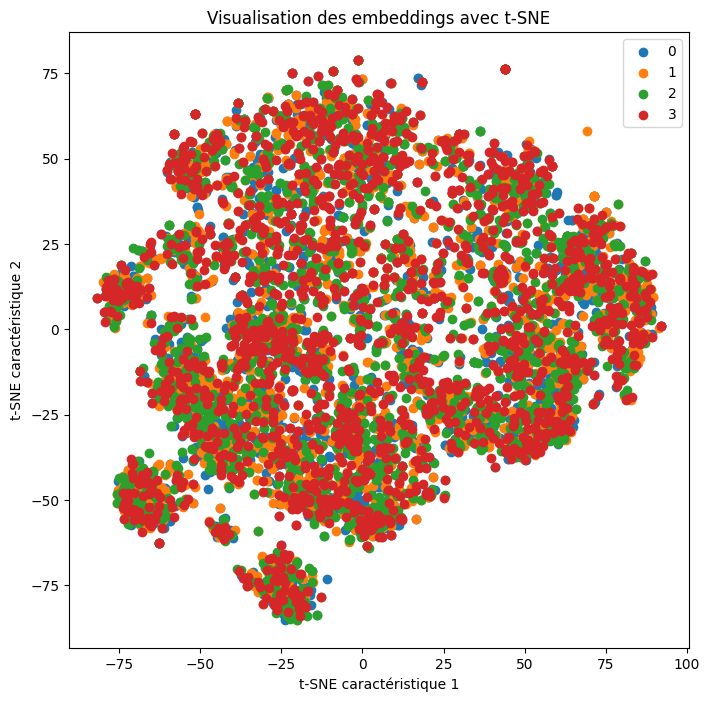

In [20]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(employee_array_test)

# Visualisation
plt.figure(figsize=(8, 8))
for class_label in np.unique(y_test):
    plt.scatter(embeddings_tsne[y_test == class_label, 0], embeddings_tsne[y_test == class_label, 1], label=class_label)

plt.legend()
plt.title("Visualisation des embeddings avec t-SNE")
plt.xlabel("t-SNE caractéristique 1")
plt.ylabel("t-SNE caractéristique 2")
plt.show()

Test sur les embeddings du test set

In [16]:
unique_classes = np.unique(y_train)
print(unique_classes)
for class_label in unique_classes:
    class_indices = np.where(y_test == class_label)[0]
    class_embeddings = employee_array_test[class_indices]
    print(class_embeddings.shape)
    # Compute cosine similarities for all pairs within the class
    sim_matrix = cosine_similarity(class_embeddings)
    print(sim_matrix.shape)
    # Since the similarity matrix includes 1.0 for self-comparisons, we remove them
    sim_matrix_no_self = sim_matrix - np.eye(sim_matrix.shape[0])
    
    # Optionally, calculate the average similarity, excluding self-comparisons
    avg_similarity = np.sum(sim_matrix_no_self) / (sim_matrix_no_self.size - sim_matrix.shape[0])
    
    print(f"Average cosine similarity within class {class_label}: {avg_similarity}")

[0 1 2 3]
(1882, 32)
(1882, 1882)
Average cosine similarity within class 0: 0.6506999485211964
(1812, 32)
(1812, 1812)
Average cosine similarity within class 1: 0.6506771925338704
(1818, 32)
(1818, 1818)
Average cosine similarity within class 2: 0.6477295104324599
(1815, 32)
(1815, 1815)
Average cosine similarity within class 3: 0.6462333947569693


In [26]:
unique_classes = np.unique(y_train)
print(unique_classes)
for class_label in unique_classes:
    class_indices = np.where(y_test == class_label)[0]
    class_embeddings = employee_array_test[class_indices]
    print(class_embeddings.shape)
    print("Vecteur moyen class", class_label, np.mean(class_embeddings, axis=0))
    # Compute cosine similarities for all pairs within the class
    sim_matrix = euclidean_distances(class_embeddings)
    print(sim_matrix.shape)
    # Since the similarity matrix includes 1.0 for self-comparisons, we remove them
    sim_matrix_no_self = sim_matrix - np.eye(sim_matrix.shape[0])
    
    # Optionally, calculate the average similarity, excluding self-comparisons
    avg_similarity = np.sum(sim_matrix_no_self) / (sim_matrix_no_self.size - sim_matrix.shape[0])
    
    print(f"Average cosine similarity within class {class_label}: {avg_similarity}")

[0 1 2 3]
(1882, 32)
Vecteur moyen class 0 [ 0.20281485 -0.13659811  0.08464289  0.2125426  -0.01995737  0.05332949
  0.491134   -0.01756974  0.17556298 -0.13218151 -0.50001806 -0.00234428
  0.8757091  -0.46227875  0.38744426 -0.00906204 -0.68266356 -0.71906334
  0.77431273 -0.03927781 -0.22771677  0.17176247  0.35500595 -0.00741736
  0.24770251  0.53486145 -0.11240982  0.4238156  -0.87821436 -0.4516571
 -0.15876378 -0.05595082]
(1882, 1882)
Average cosine similarity within class 0: 2.3401052794382595
(1812, 32)
Vecteur moyen class 1 [ 0.18875197 -0.15827966  0.07706068  0.22924162 -0.0129561   0.07127767
  0.49042746 -0.02386225  0.17309102 -0.13036498 -0.49475053 -0.00682231
  0.87596035 -0.46884388  0.38435167  0.00598109 -0.68079245 -0.7274865
  0.777862   -0.02392612 -0.23109205  0.16092841  0.35319668 -0.00399665
  0.25266296  0.5421242  -0.10129988  0.41980645 -0.8785145  -0.4442011
 -0.15487373 -0.04993025]
(1812, 1812)
Average cosine similarity within class 1: 2.34261423664829

In [19]:
# Iterate over pairs of classes
for i in range(4):
    for j in range(i+1, 4):
        # Indices and embeddings for class i
        class_i_indices = np.where(y_train == unique_classes[i])[0]
        class_i_embeddings = employee_array[class_i_indices]
        
        # Indices and embeddings for class j
        class_j_indices = np.where(y_train == unique_classes[j])[0]
        class_j_embeddings = employee_array[class_j_indices]
        print("i", class_i_embeddings.shape)
        print("j", class_j_embeddings.shape)
        # Compute cosine similarities between all pairs (i, j)
        sim_matrix = cosine_similarity(class_i_embeddings, class_j_embeddings)
        print(sim_matrix.shape)
        # Calculate the average similarity across classes
        avg_similarity = np.mean(sim_matrix)
        
        print(f"Average cosine similarity between class {unique_classes[i]} and class {unique_classes[j]}: {avg_similarity}")

i (9023, 32)
j (17793, 32)
(9023, 17793)
Average cosine similarity between class 0 and class 1: 0.6536845564842224
i (9023, 32)
j (1101, 32)
(9023, 1101)
Average cosine similarity between class 0 and class 2: 0.6583091020584106
i (9023, 32)
j (1356, 32)
(9023, 1356)
Average cosine similarity between class 0 and class 3: 0.6520729660987854
i (17793, 32)
j (1101, 32)
(17793, 1101)
Average cosine similarity between class 1 and class 2: 0.6696447134017944
i (17793, 32)
j (1356, 32)
(17793, 1356)
Average cosine similarity between class 1 and class 3: 0.6529146432876587
i (1101, 32)
j (1356, 32)
(1101, 1356)
Average cosine similarity between class 2 and class 3: 0.6635869145393372


In [29]:
combined_tensor.shape

torch.Size([29273, 64])

In [31]:
torch.tensor(y_train).shape

torch.Size([29273])

# Contrastive Learning

In [70]:


class EmbeddingAdjustmentModel(nn.Module):
    def __init__(self, embedding_dim, output_dim):
        super(EmbeddingAdjustmentModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x


In [74]:


class TripletDataset(Dataset):
    """Dataset pour générer des triplets."""
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
        self.index = 0
    
    def __getitem__(self, index):
        # Sélectionnez l'ancre, le positif et le négatif ici
        # Cela dépend de votre méthode de sélection des triplets
        anchor = self.embeddings[index]
        label = self.labels[index]
    
        positive= self.choose_positive(label)
        negative = self.choose_negative(label)
        
        
        return anchor, positive, negative
    
    def __len__(self):
        return len(self.embeddings)
    
    def choose_positive(self, label):
        # Implémentez la logique pour choisir un positif
        indices = torch.where(self.labels==label)
        #print('indice', indices)
        tensor_same_class = self.embeddings[indices]
        #print(tensor_same_class.shape)  
        chosen = torch.randint(0, tensor_same_class.shape[0], size=(1,)).item()

        return tensor_same_class[chosen] 
    
    def choose_negative(self, label):
        # Implémentez la logique pour choisir un négatif
        indices = torch.where(self.labels!=label)
        #print('indice', indices)
        tensor_diff_class = self.embeddings[indices]
        #print(tensor_diff_class.shape)   
        chosen = torch.randint(0, tensor_diff_class.shape[0], size=(1,)).item()

        return tensor_diff_class[chosen]

# Initialisation du modèle, du DataLoader, etc.
embedding_dim = combined_tensor.shape[1]
output_dim = 32
num_epochs = 100
device = ('cpu')
#model = EmbeddingAdjustmentModel(embedding_dim, output_dim)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.TripletMarginLoss(margin=1.0)
target =  torch.tensor(y_train)
dataset = TripletDataset(combined_tensor, target)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Boucle d'entraînement
for epoch in tqdm(range(num_epochs)):
    for anchor, positive, negative in dataloader:
        optimizer.zero_grad()
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        anchor_embed = model(anchor)
        positive_embed = model(positive)
        negative_embed = model(negative)
        
        loss = criterion(anchor_embed, positive_embed, negative_embed)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")


  1%|          | 1/100 [44:57<74:10:32, 2697.30s/it]

Epoch [1/100], Loss: 0.540036678314209


  2%|▏         | 2/100 [1:11:18<55:33:30, 2040.93s/it]

Epoch [2/100], Loss: 0.7649509310722351


  3%|▎         | 3/100 [1:18:04<34:52:45, 1294.49s/it]

Epoch [3/100], Loss: 0.5613411068916321


  4%|▍         | 4/100 [1:25:56<25:51:26, 969.65s/it] 

Epoch [4/100], Loss: 0.4011843204498291


  5%|▌         | 5/100 [1:33:07<20:27:33, 775.30s/it]

Epoch [5/100], Loss: 0.6211049556732178


  6%|▌         | 6/100 [1:46:24<20:26:25, 782.82s/it]

Epoch [6/100], Loss: 0.33778899908065796


  7%|▋         | 7/100 [1:53:33<17:13:45, 666.94s/it]

Epoch [7/100], Loss: 0.5243014693260193


  8%|▊         | 8/100 [2:00:24<14:58:01, 585.67s/it]

Epoch [8/100], Loss: 0.5541859269142151


  9%|▉         | 9/100 [2:07:48<13:40:49, 541.20s/it]

Epoch [9/100], Loss: 0.49339374899864197


 10%|█         | 10/100 [2:14:48<12:35:47, 503.86s/it]

Epoch [10/100], Loss: 0.665067732334137


 11%|█         | 11/100 [2:38:36<19:26:47, 786.60s/it]

Epoch [11/100], Loss: 0.6732469797134399


 12%|█▏        | 12/100 [2:47:47<17:28:43, 715.04s/it]

Epoch [12/100], Loss: 0.42673787474632263


 13%|█▎        | 13/100 [2:56:21<15:48:40, 654.26s/it]

Epoch [13/100], Loss: 0.45815059542655945


 14%|█▍        | 14/100 [3:04:25<14:24:03, 602.83s/it]

Epoch [14/100], Loss: 0.5268642902374268


 15%|█▌        | 15/100 [3:12:39<13:27:18, 569.87s/it]

Epoch [15/100], Loss: 0.42285698652267456


 16%|█▌        | 16/100 [3:20:39<12:39:57, 542.83s/it]

Epoch [16/100], Loss: 0.4933449923992157


 17%|█▋        | 17/100 [3:28:38<12:04:14, 523.54s/it]

Epoch [17/100], Loss: 0.32255667448043823


 18%|█▊        | 18/100 [3:37:03<11:48:12, 518.20s/it]

Epoch [18/100], Loss: 0.5273322463035583


 19%|█▉        | 19/100 [3:48:12<12:40:39, 563.45s/it]

Epoch [19/100], Loss: 0.5589088797569275


 20%|██        | 20/100 [3:59:47<13:23:58, 602.99s/it]

Epoch [20/100], Loss: 0.5210264921188354


 21%|██        | 21/100 [4:10:24<13:27:24, 613.22s/it]

Epoch [21/100], Loss: 0.47178757190704346


 22%|██▏       | 22/100 [4:20:30<13:14:08, 610.87s/it]

Epoch [22/100], Loss: 0.5675848722457886


 23%|██▎       | 23/100 [4:30:53<13:08:43, 614.59s/it]

Epoch [23/100], Loss: 0.3129535913467407


 24%|██▍       | 24/100 [4:41:34<13:08:27, 622.47s/it]

Epoch [24/100], Loss: 0.5415186882019043


 25%|██▌       | 25/100 [5:07:20<18:44:32, 899.63s/it]

Epoch [25/100], Loss: 0.35467982292175293


 26%|██▌       | 26/100 [5:17:25<16:40:34, 811.28s/it]

Epoch [26/100], Loss: 0.4595910608768463


 27%|██▋       | 27/100 [5:26:53<14:58:04, 738.14s/it]

Epoch [27/100], Loss: 0.3056975305080414


 28%|██▊       | 28/100 [5:35:51<13:33:37, 678.02s/it]

Epoch [28/100], Loss: 0.49435845017433167


 29%|██▉       | 29/100 [7:23:10<47:27:34, 2406.39s/it]

Epoch [29/100], Loss: 0.5287632942199707


 30%|███       | 30/100 [7:33:14<36:16:35, 1865.65s/it]

Epoch [30/100], Loss: 0.5516043901443481


 31%|███       | 31/100 [7:42:25<28:12:08, 1471.43s/it]

Epoch [31/100], Loss: 0.41112351417541504


 32%|███▏      | 32/100 [7:51:38<22:35:22, 1195.92s/it]

Epoch [32/100], Loss: 0.6333831548690796


 33%|███▎      | 33/100 [9:03:04<39:30:27, 2122.80s/it]

Epoch [33/100], Loss: 0.5338558554649353


 34%|███▍      | 34/100 [9:07:34<28:43:44, 1567.03s/it]

Epoch [34/100], Loss: 0.2782452404499054


 35%|███▌      | 35/100 [9:11:36<21:06:49, 1169.37s/it]

Epoch [35/100], Loss: 0.4062117636203766


 36%|███▌      | 36/100 [9:14:21<15:26:04, 868.19s/it] 

Epoch [36/100], Loss: 0.7568092346191406


 37%|███▋      | 37/100 [9:17:16<11:33:18, 660.30s/it]

Epoch [37/100], Loss: 0.3765539824962616


 38%|███▊      | 38/100 [9:20:26<8:56:30, 519.20s/it] 

Epoch [38/100], Loss: 0.4435386657714844


 39%|███▉      | 39/100 [9:23:15<7:00:51, 413.95s/it]

Epoch [39/100], Loss: 0.4128950536251068


 40%|████      | 40/100 [9:25:57<5:38:27, 338.45s/it]

Epoch [40/100], Loss: 0.48773106932640076


 41%|████      | 41/100 [9:28:41<4:41:26, 286.20s/it]

Epoch [41/100], Loss: 0.3100377023220062


 42%|████▏     | 42/100 [9:32:04<4:12:38, 261.35s/it]

Epoch [42/100], Loss: 0.5279582738876343


 43%|████▎     | 43/100 [9:35:28<3:51:48, 244.00s/it]

Epoch [43/100], Loss: 0.600106954574585


 44%|████▍     | 44/100 [9:38:47<3:35:15, 230.63s/it]

Epoch [44/100], Loss: 0.36374545097351074


 45%|████▌     | 45/100 [9:41:46<3:17:00, 214.92s/it]

Epoch [45/100], Loss: 0.4142543375492096


 46%|████▌     | 46/100 [9:44:20<2:56:58, 196.64s/it]

Epoch [46/100], Loss: 0.4582207500934601


 47%|████▋     | 47/100 [9:46:54<2:42:24, 183.86s/it]

Epoch [47/100], Loss: 0.32869893312454224


 48%|████▊     | 48/100 [9:49:29<2:31:47, 175.15s/it]

Epoch [48/100], Loss: 0.3442344665527344


 49%|████▉     | 49/100 [9:52:04<2:23:52, 169.26s/it]

Epoch [49/100], Loss: 0.4075514078140259


 50%|█████     | 50/100 [9:54:39<2:17:35, 165.11s/it]

Epoch [50/100], Loss: 0.3595333993434906


 51%|█████     | 51/100 [9:57:15<2:12:23, 162.12s/it]

Epoch [51/100], Loss: 0.43724334239959717


 52%|█████▏    | 52/100 [9:59:49<2:07:52, 159.85s/it]

Epoch [52/100], Loss: 0.3634631335735321


 53%|█████▎    | 53/100 [10:02:26<2:04:24, 158.83s/it]

Epoch [53/100], Loss: 0.49948379397392273


 54%|█████▍    | 54/100 [10:06:22<2:19:31, 181.99s/it]

Epoch [54/100], Loss: 0.4016936123371124


 55%|█████▌    | 55/100 [10:09:29<2:17:36, 183.47s/it]

Epoch [55/100], Loss: 0.45063766837120056


 56%|█████▌    | 56/100 [10:12:36<2:15:26, 184.69s/it]

Epoch [56/100], Loss: 0.34996163845062256


 57%|█████▋    | 57/100 [10:15:47<2:13:36, 186.44s/it]

Epoch [57/100], Loss: 0.5152828693389893


 58%|█████▊    | 58/100 [10:18:58<2:11:32, 187.92s/it]

Epoch [58/100], Loss: 0.49319884181022644


 59%|█████▉    | 59/100 [10:22:09<2:08:57, 188.71s/it]

Epoch [59/100], Loss: 0.30156996846199036


 60%|██████    | 60/100 [10:25:17<2:05:44, 188.61s/it]

Epoch [60/100], Loss: 0.3034829795360565


 61%|██████    | 61/100 [10:28:49<2:07:04, 195.49s/it]

Epoch [61/100], Loss: 0.2657056152820587


 62%|██████▏   | 62/100 [10:32:09<2:04:42, 196.90s/it]

Epoch [62/100], Loss: 0.24282771348953247


 63%|██████▎   | 63/100 [10:35:13<1:59:08, 193.19s/it]

Epoch [63/100], Loss: 0.43390244245529175


 64%|██████▍   | 64/100 [10:38:38<1:58:03, 196.75s/it]

Epoch [64/100], Loss: 0.30993548035621643


 65%|██████▌   | 65/100 [10:42:09<1:57:10, 200.86s/it]

Epoch [65/100], Loss: 0.5780408382415771


 66%|██████▌   | 66/100 [10:46:22<2:02:43, 216.57s/it]

Epoch [66/100], Loss: 0.40359413623809814


 67%|██████▋   | 67/100 [10:50:41<2:06:10, 229.41s/it]

Epoch [67/100], Loss: 0.2313990443944931


 68%|██████▊   | 68/100 [10:54:26<2:01:39, 228.12s/it]

Epoch [68/100], Loss: 0.2644810080528259


 69%|██████▉   | 69/100 [10:59:09<2:06:17, 244.42s/it]

Epoch [69/100], Loss: 0.4924761652946472


 70%|███████   | 70/100 [11:03:21<2:03:18, 246.62s/it]

Epoch [70/100], Loss: 0.26304158568382263


 71%|███████   | 71/100 [11:06:42<1:52:35, 232.96s/it]

Epoch [71/100], Loss: 0.24427279829978943


 72%|███████▏  | 72/100 [11:09:37<1:40:37, 215.62s/it]

Epoch [72/100], Loss: 0.2439180612564087


 73%|███████▎  | 73/100 [11:12:28<1:31:02, 202.32s/it]

Epoch [73/100], Loss: 0.3289411664009094


 74%|███████▍  | 74/100 [11:16:00<1:28:55, 205.22s/it]

Epoch [74/100], Loss: 0.34256336092948914


 75%|███████▌  | 75/100 [11:19:43<1:27:45, 210.63s/it]

Epoch [75/100], Loss: 0.33658120036125183


 76%|███████▌  | 76/100 [11:23:32<1:26:27, 216.14s/it]

Epoch [76/100], Loss: 0.1306178867816925


 77%|███████▋  | 77/100 [11:27:25<1:24:45, 221.13s/it]

Epoch [77/100], Loss: 0.41746261715888977


 78%|███████▊  | 78/100 [11:30:36<1:17:43, 211.99s/it]

Epoch [78/100], Loss: 0.5801761150360107


 79%|███████▉  | 79/100 [11:33:47<1:12:02, 205.85s/it]

Epoch [79/100], Loss: 0.3336927890777588


 80%|████████  | 80/100 [11:36:53<1:06:32, 199.64s/it]

Epoch [80/100], Loss: 0.1903962343931198


 81%|████████  | 81/100 [11:40:26<1:04:29, 203.65s/it]

Epoch [81/100], Loss: 0.24728891253471375


 82%|████████▏ | 82/100 [11:44:38<1:05:28, 218.24s/it]

Epoch [82/100], Loss: 0.2711876928806305


 83%|████████▎ | 83/100 [11:48:48<1:04:33, 227.83s/it]

Epoch [83/100], Loss: 0.3603898286819458


 84%|████████▍ | 84/100 [11:52:35<1:00:41, 227.62s/it]

Epoch [84/100], Loss: 0.326003760099411


 85%|████████▌ | 85/100 [11:56:29<57:21, 229.45s/it]  

Epoch [85/100], Loss: 0.4355655908584595


 86%|████████▌ | 86/100 [12:00:36<54:46, 234.72s/it]

Epoch [86/100], Loss: 0.41586416959762573


 87%|████████▋ | 87/100 [12:04:48<52:00, 240.07s/it]

Epoch [87/100], Loss: 0.36600714921951294


 88%|████████▊ | 88/100 [12:08:36<47:14, 236.20s/it]

Epoch [88/100], Loss: 0.46036651730537415


 89%|████████▉ | 89/100 [12:12:22<42:47, 233.39s/it]

Epoch [89/100], Loss: 0.3791602849960327


 90%|█████████ | 90/100 [12:15:58<37:59, 227.92s/it]

Epoch [90/100], Loss: 0.357228547334671


 91%|█████████ | 91/100 [12:19:28<33:24, 222.70s/it]

Epoch [91/100], Loss: 0.2872767746448517


 92%|█████████▏| 92/100 [12:22:42<28:31, 213.91s/it]

Epoch [92/100], Loss: 0.304133802652359


 93%|█████████▎| 93/100 [12:26:57<26:25, 226.47s/it]

Epoch [93/100], Loss: 0.19176243245601654


 94%|█████████▍| 94/100 [12:30:32<22:17, 222.93s/it]

Epoch [94/100], Loss: 0.15785619616508484


 95%|█████████▌| 95/100 [12:34:01<18:13, 218.75s/it]

Epoch [95/100], Loss: 0.6162868738174438


 96%|█████████▌| 96/100 [12:37:26<14:18, 214.66s/it]

Epoch [96/100], Loss: 0.4056888520717621


 97%|█████████▋| 97/100 [12:41:00<10:43, 214.45s/it]

Epoch [97/100], Loss: 0.5541338920593262


 98%|█████████▊| 98/100 [12:44:28<07:04, 212.50s/it]

Epoch [98/100], Loss: 0.2233925461769104


 99%|█████████▉| 99/100 [12:47:59<03:32, 212.05s/it]

Epoch [99/100], Loss: 0.25934427976608276


100%|██████████| 100/100 [12:51:27<00:00, 462.88s/it]

Epoch [100/100], Loss: 0.3076271116733551


In [79]:
# Save model 

torch.save(model.state_dict(), "/Users/louisedurand-janin/Documents/GitHub/HrFlow_Data_Challenge/model_contrast_32.pt")

In [75]:
model.eval()

new_embeddings_train = model(combined_tensor)

In [57]:
combined_tensor

tensor([[ 0.0133, -0.3762, -0.6138,  ..., -0.4219, -0.3206, -0.4043],
        [-0.2827, -0.0129,  0.2054,  ..., -0.1548,  0.0759, -0.6390],
        [ 0.4000, -0.2985, -0.2110,  ..., -0.5598,  0.1031, -0.1492],
        ...,
        [-0.2505, -0.2068,  0.5609,  ..., -0.1784, -0.3287, -0.4991],
        [-0.2505, -0.2068,  0.5609,  ..., -0.8119,  0.0043,  0.2834],
        [-0.6191, -0.0630, -0.2045,  ..., -0.3501, -0.6396, -0.5535]])

In [76]:
new_array_train = np.array(new_embeddings_train.detach().numpy())
new_array_train.shape

(29273, 32)

In [77]:
unique_classes = np.unique(y_train)
print(unique_classes)
for class_label in unique_classes:
    class_indices = np.where(y_train == class_label)[0]
    class_embeddings = new_array_train[class_indices]
    print(class_embeddings.shape)
    # Compute cosine similarities for all pairs within the class
    sim_matrix = cosine_similarity(class_embeddings)
    print(sim_matrix.shape)
    # Since the similarity matrix includes 1.0 for self-comparisons, we remove them
    sim_matrix_no_self = sim_matrix - np.eye(sim_matrix.shape[0])
    
    # Optionally, calculate the average similarity, excluding self-comparisons
    avg_similarity = np.sum(sim_matrix_no_self) / (sim_matrix_no_self.size - sim_matrix.shape[0])
    
    print(f"Average cosine similarity within class {class_label}: {avg_similarity}")

[0 1 2 3]
(9023, 32)


(9023, 9023)
Average cosine similarity within class 0: 0.8719801065719593
(17793, 32)
(17793, 17793)
Average cosine similarity within class 1: 0.8823739645256011
(1101, 32)
(1101, 1101)
Average cosine similarity within class 2: 0.5652546716482155
(1356, 32)
(1356, 1356)
Average cosine similarity within class 3: 0.5548956930224196


In [78]:
# Iterate over pairs of classes
for i in range(4):
    for j in range(i+1, 4):
        # Indices and embeddings for class i
        class_i_indices = np.where(y_train == unique_classes[i])[0]
        class_i_embeddings = new_array_train[class_i_indices]
        
        # Indices and embeddings for class j
        class_j_indices = np.where(y_train == unique_classes[j])[0]
        class_j_embeddings = new_array_train[class_j_indices]
        
        # Compute cosine similarities between all pairs (i, j)
        sim_matrix = cosine_similarity(class_i_embeddings, class_j_embeddings)
        
        # Calculate the average similarity across classes
        avg_similarity = np.mean(sim_matrix)
        
        print(f"Average cosine similarity between class {unique_classes[i]} and class {unique_classes[j]}: {avg_similarity}")

Average cosine similarity between class 0 and class 1: 0.2871655821800232
Average cosine similarity between class 0 and class 2: 0.4333949089050293
Average cosine similarity between class 0 and class 3: 0.6077513694763184
Average cosine similarity between class 1 and class 2: 0.6562576293945312
Average cosine similarity between class 1 and class 3: 0.48463737964630127
Average cosine similarity between class 2 and class 3: 0.49804461002349854
